In [1]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score  
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import geopy as gp
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
from datetime import datetime

geolocator = Nominatim()
location = geolocator.geocode("175 5th Avenue NYC")
print(location)

Flatiron Building, 175, 5th Avenue, Flatiron Building, Manhattan Community Board 5, New York County, NYC, New York, 10010, United States of America


### Read in The training and Test Data csv file and Also Preview their Columns

In [2]:
train_demo = pd.read_csv('../output/train_spray_weather.csv')
train_demo.head()
train_demo.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Day', 'spray_info',
       'SprayDate', 'SprayDistance', 'SprayLatitude', 'SprayLongitude',
       'Weather_Info', 'HeatMonthAvg', 'CoolMonthAvg', 'PrecipMonthAvg',
       'WetBulbMonthAvg', 'DewPointMonthAvg'],
      dtype='object')

In [3]:
# Checking the training data set dimension
train_demo.shape

(10506, 26)

In [4]:
test_demo = pd.read_csv('../output/test_spray_weather.csv')
test_demo.head()
test_demo.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Year', 'Month', 'Day', 'Weather_Info', 'HeatMonthAvg', 'CoolMonthAvg',
       'PrecipMonthAvg', 'WetBulbMonthAvg', 'DewPointMonthAvg'],
      dtype='object')

In [5]:
# checking the dimension of the test data set
test_demo.shape

(116293, 20)

### descriptive summary of training dataset 

In [9]:
train_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 26 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
Year                      10506 non-null int64
Month                     10506 non-null int64
Day                       10506 non-null int64
spray_info                10506 non-null object
SprayDate                 2195 non-null object
SprayDistance             10506 non-null float64
SprayLatitude             10506 

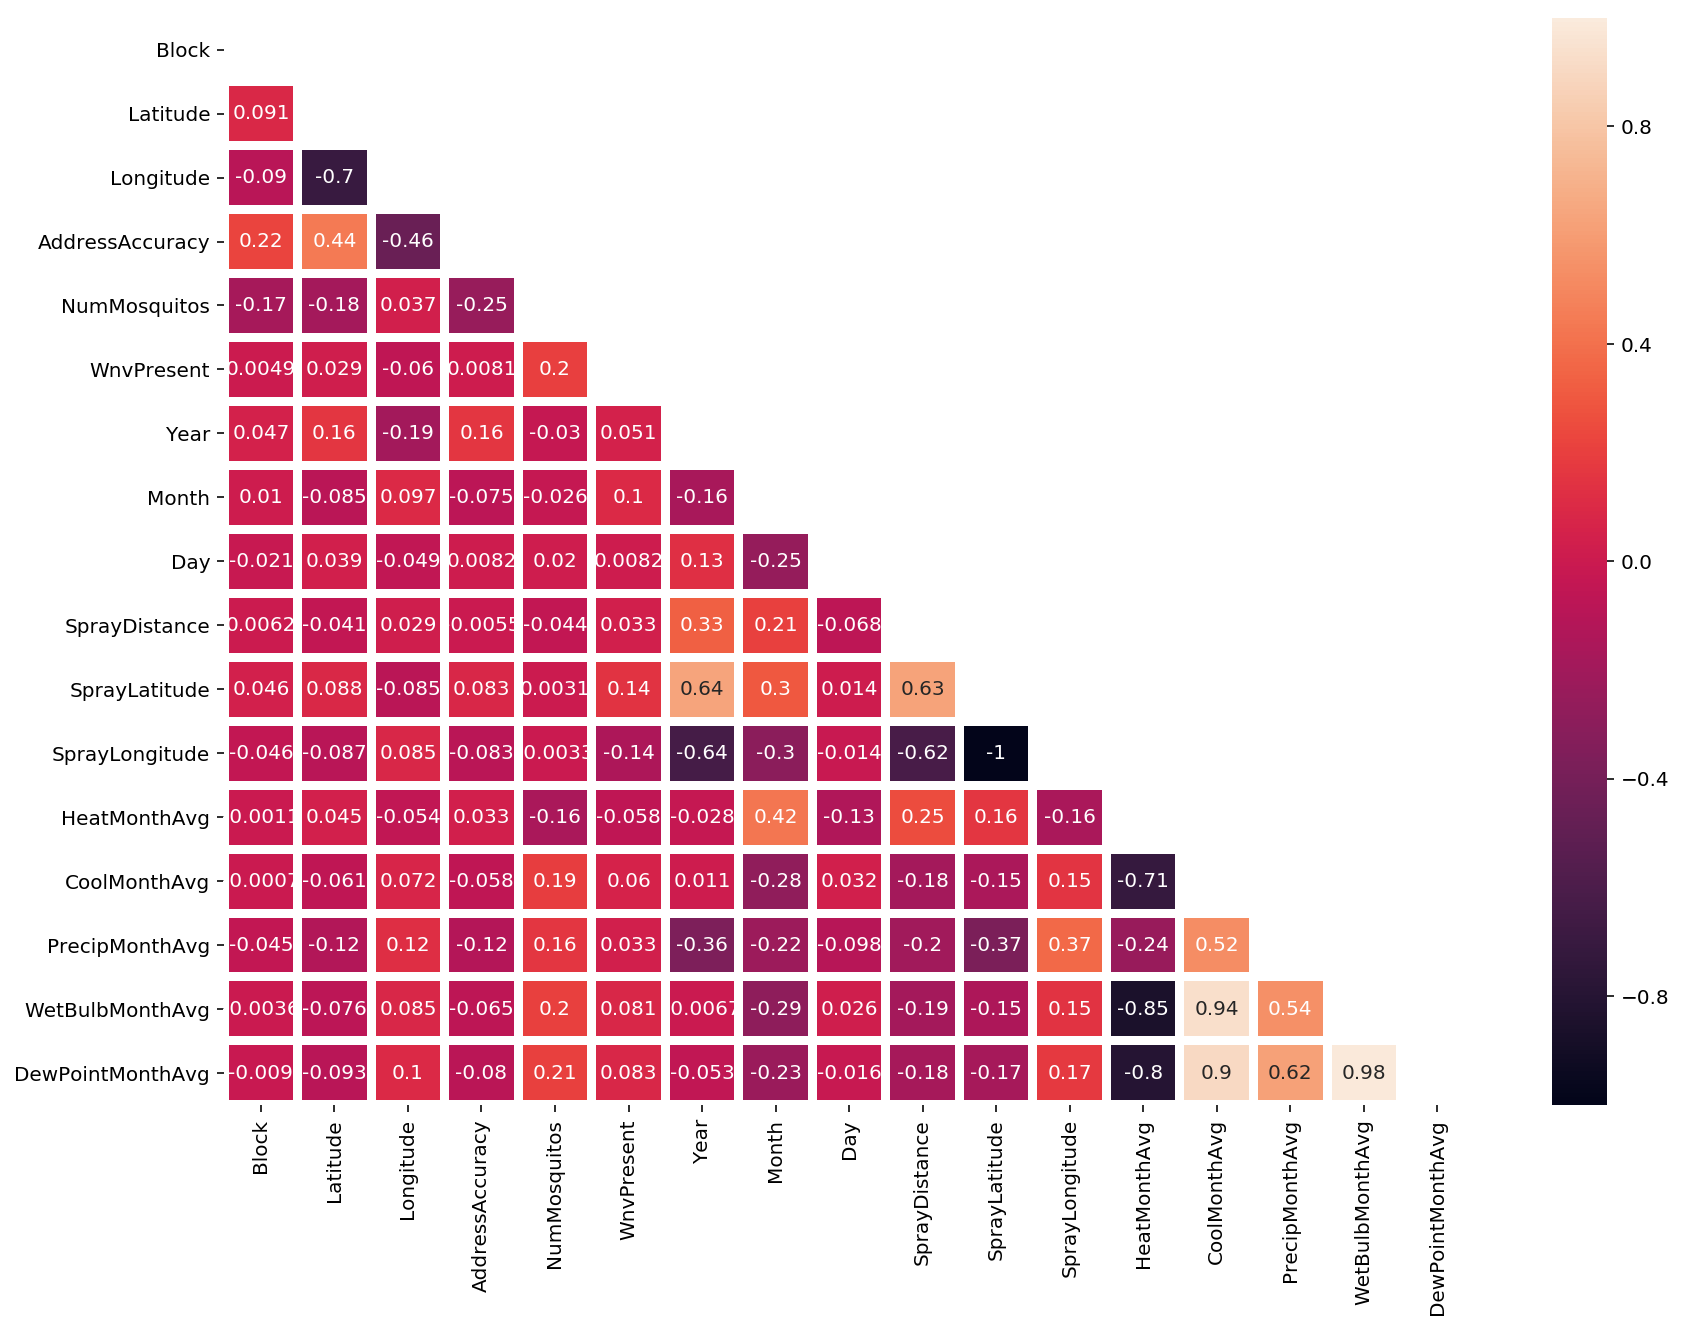

In [413]:
#Plot to show the correlation among the variables of the train dataset
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.zeros_like(train_demo.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_demo.corr(), linewidths=4, annot=True, mask=mask, ax=ax)

In [11]:
train_demo.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,SprayDate,SprayDistance,SprayLatitude,SprayLongitude,Weather_Info,HeatMonthAvg,CoolMonthAvg,PrecipMonthAvg,WetBulbMonthAvg,DewPointMonthAvg
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,NaN,0.0,0.0,0.0,3|3|0.0636|55|46,3,3,0.0636,55,46
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,NaN,0.0,0.0,0.0,3|3|0.0636|55|46,3,3,0.0636,55,46


### First need to understand the spread of Number of Mosquitos recorded monthly and also Annualy. So the below graphs shows that. The first graph shows the  Monthly distribution of Mosquitos caught and the later shows the Year with the highest number of mosquitos recorded in the training data set

In [ ]:
train_demo

In [289]:
# To see what month has the most record of mosquitos number

train_demo.groupby('Month')['Trap'].count().sort_values(ascending=False)

Month
8     3751
7     2606
9     2218
6     1571
10     276
5       84
Name: Trap, dtype: int64

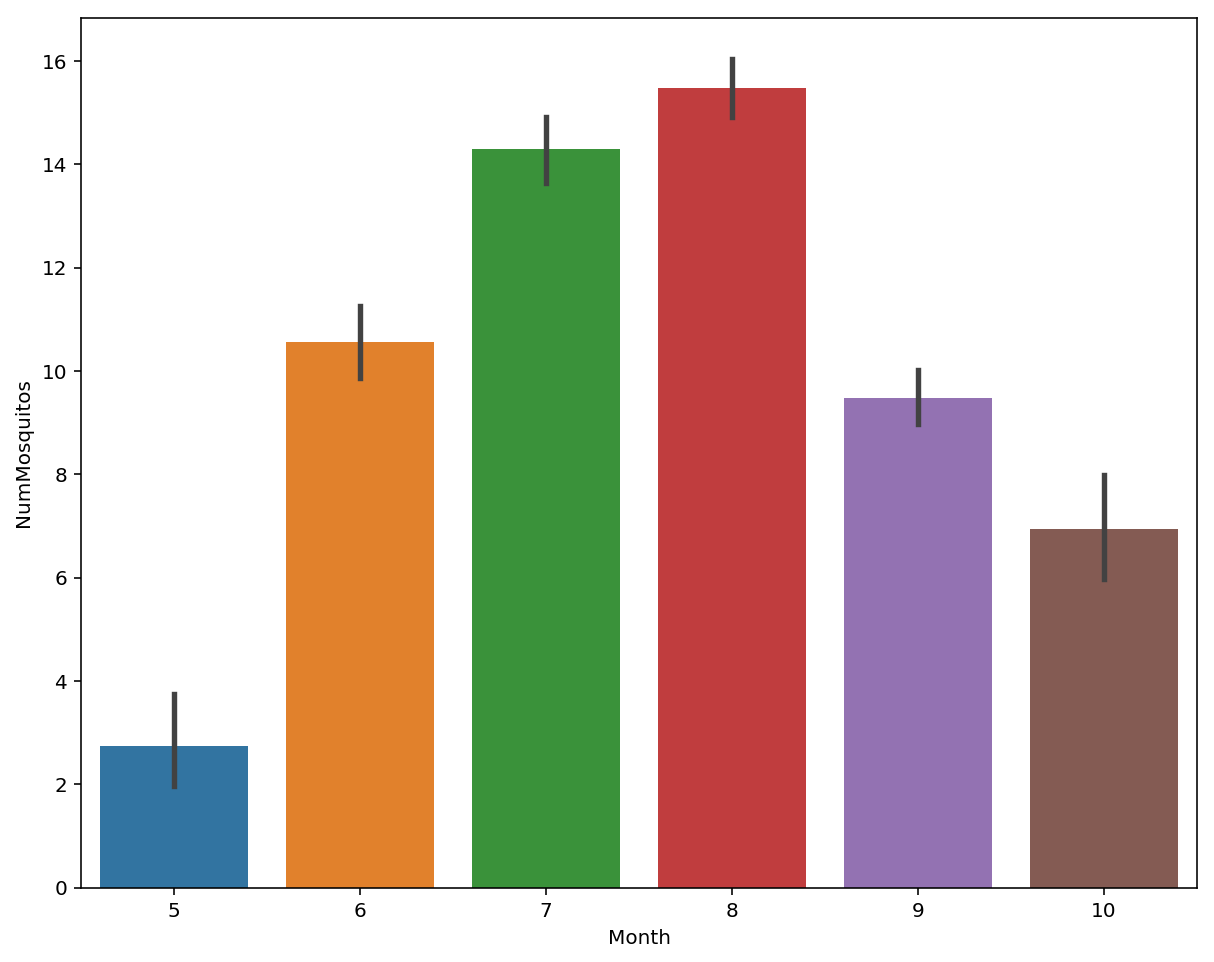

In [13]:
# Monthly number of mosquitos recorded in the training dataset
fig, ax = plt.subplots(figsize=(10,8))  
sns.barplot(x='Month', y='NumMosquitos', data=train_demo,  ax=ax)

In [33]:
# To see what Year has the most record of mosquitos number

train_demo.groupby('Year')['NumMosquitos'].count().sort_values(ascending=False)

Year
2007    3811
2013    2392
2009    2249
2011    2054
Name: NumMosquitos, dtype: int64

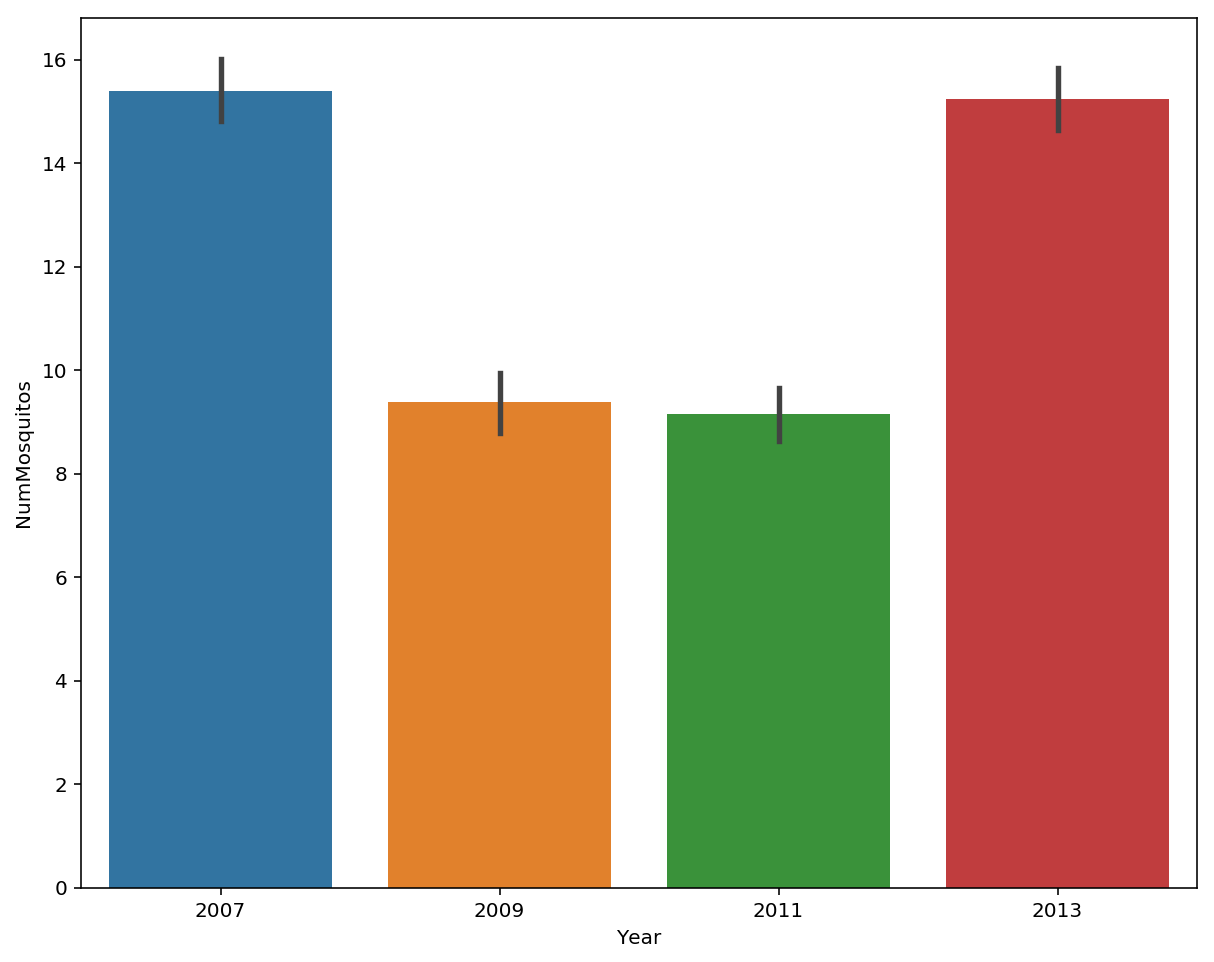

In [34]:
# Yearly number of mosquitos recorded in our training dataset 
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Year', y='NumMosquitos', data=train_demo,  ax=ax)

### So it makes sense to understand what particular species of mosquitos is prevalent so as to be able to identitfy which of them is associated with west-nile virus outbreak the most

In [29]:
# Species observations
train_demo.Species.value_counts() 

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

Text(0,0.5,'Species')

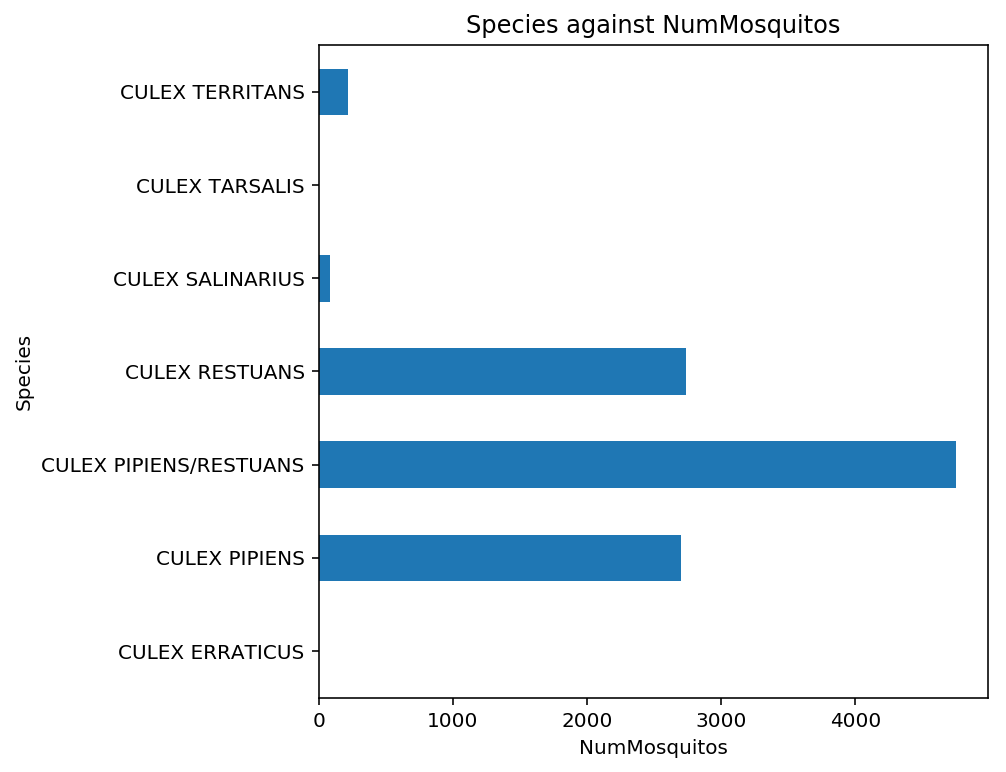

In [291]:
# Graph showing the most prevalent Mosquitoe Species
fig, ax = plt.subplots(figsize = (6, 6))
train_demo.groupby('Species')['NumMosquitos'].count().plot('barH', ax = ax, title = 'Species against NumMosquitos')
plt.xlabel('NumMosquitos')
plt.ylabel('Species')


### Filtering the data set where WnvPresent is yes[1] and assigning to a variable, In that way i could easily find out which Specie of mosquitos is most associated with west-nile virus outbreak

In [36]:
# subset where west-nile virus is present
wnv_set = train_demo[train_demo['WnvPresent'] == 1]
wnv_set.shape

(551, 26)

#### Looking at the species number below you see that Cules Pipiens/Restuans is the most but i would also be careful with culex pipiens considering the ratio. So it will be of great benefit to concentrate more pesticide spraying or traping in areas where Culex Pipiens are found also

In [40]:
# The most prevalent species associated with west-nile virus outbreak
wnv_set['Species'].value_counts()

CULEX PIPIENS/RESTUANS    262
CULEX PIPIENS             240
CULEX RESTUANS             49
Name: Species, dtype: int64

Text(0,0.5,'NumMosquitos')

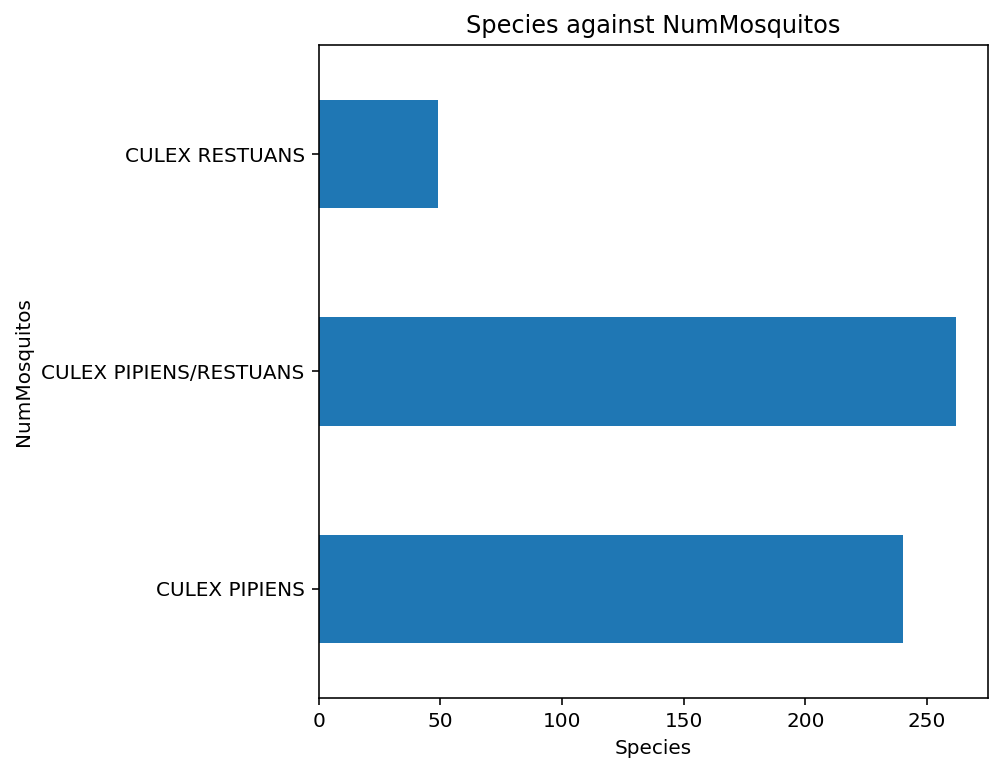

In [307]:
# Graph showing the most prevalent Mosquitoe Species associated with virus outbreak
fig, ax = plt.subplots(figsize = (6, 6))
wnv_set.groupby('Species')['NumMosquitos'].count().plot('barH', ax = ax, title = 'Species against NumMosquitos')
plt.xlabel('Species')
plt.ylabel('NumMosquitos')


### Looking at the data set where west-nile virus present is True ,One can as well find out what month occured the most relative to the virus outbreak

In [400]:
# From the subset where west-nile virus present is True
wnv_set.groupby(['Month'])['NumMosquitos'].count().sort_values(ascending=False)

Month
8     377
9     125
7      46
10      2
6       1
Name: NumMosquitos, dtype: int64

Text(0,0.5,'NumMosquitos')

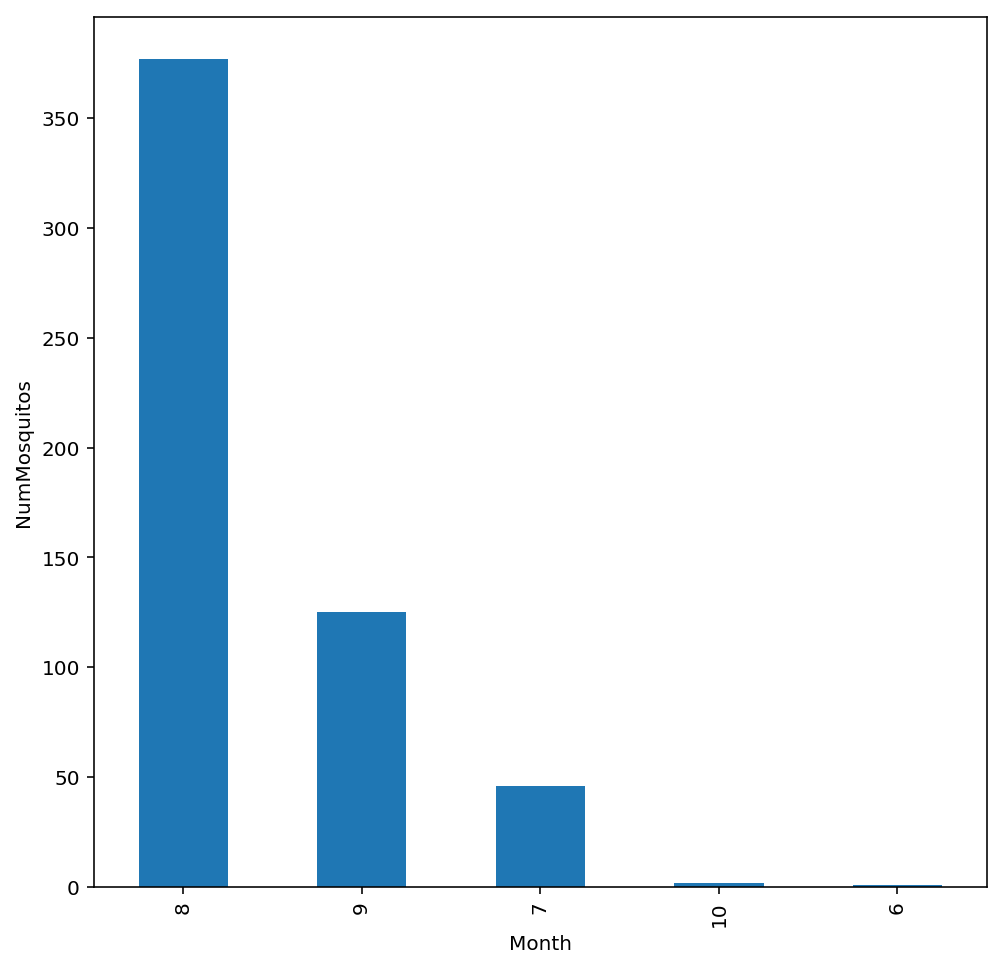

In [401]:
# Grap Showing the most prevalent month of west-nile virus outbreak
fig, ax = plt.subplots(figsize=(8,8)) 
wnv_set.groupby(['Month'])['NumMosquitos'].count().sort_values(ascending=False).head(20).plot('bar',ax=ax)
plt.xlabel('Month')
plt.ylabel('NumMosquitos')

#### Now we need to know locations with the highest number of virus outbreak so as to  know the prevalent specie, weather condition and time

We look at the Location first, then look at the different weather conditions and finally the time, So here are the steps:
1. Subset the dataframe where west-nile virus is True

2. Then group all the locations therein to find which has the highest occurrance of west-nile virus reported

3. Then group all the location again find which has the highest average Heat annualy as observed

4. Group the locations find which has the highest average Precipitate as observed

5. Group the locations find which has the most Wetbulb weather condition

6. Group the locations find which has the most Cool weather condition

7. Group the locations find which has the most Dew point weather condition

In [109]:
train_demo.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Day', 'spray_info',
       'SprayDate', 'SprayDistance', 'SprayLatitude', 'SprayLongitude',
       'Weather_Info', 'HeatMonthAvg', 'CoolMonthAvg', 'PrecipMonthAvg',
       'WetBulbMonthAvg', 'DewPointMonthAvg'],
      dtype='object')

In [309]:
# Location with the most outbreak
wnv_set.groupby(['Latitude','Longitude'])['WnvPresent'].sum().reset_index().sort_values(by='WnvPresent',ascending=False).head(3)

,Latitude,Longitude,WnvPresent
86,41.974689,-87.890615,66
3,41.673408,-87.599862,41
79,41.954690,-87.800991,18


Text(0,0.5,'Location')

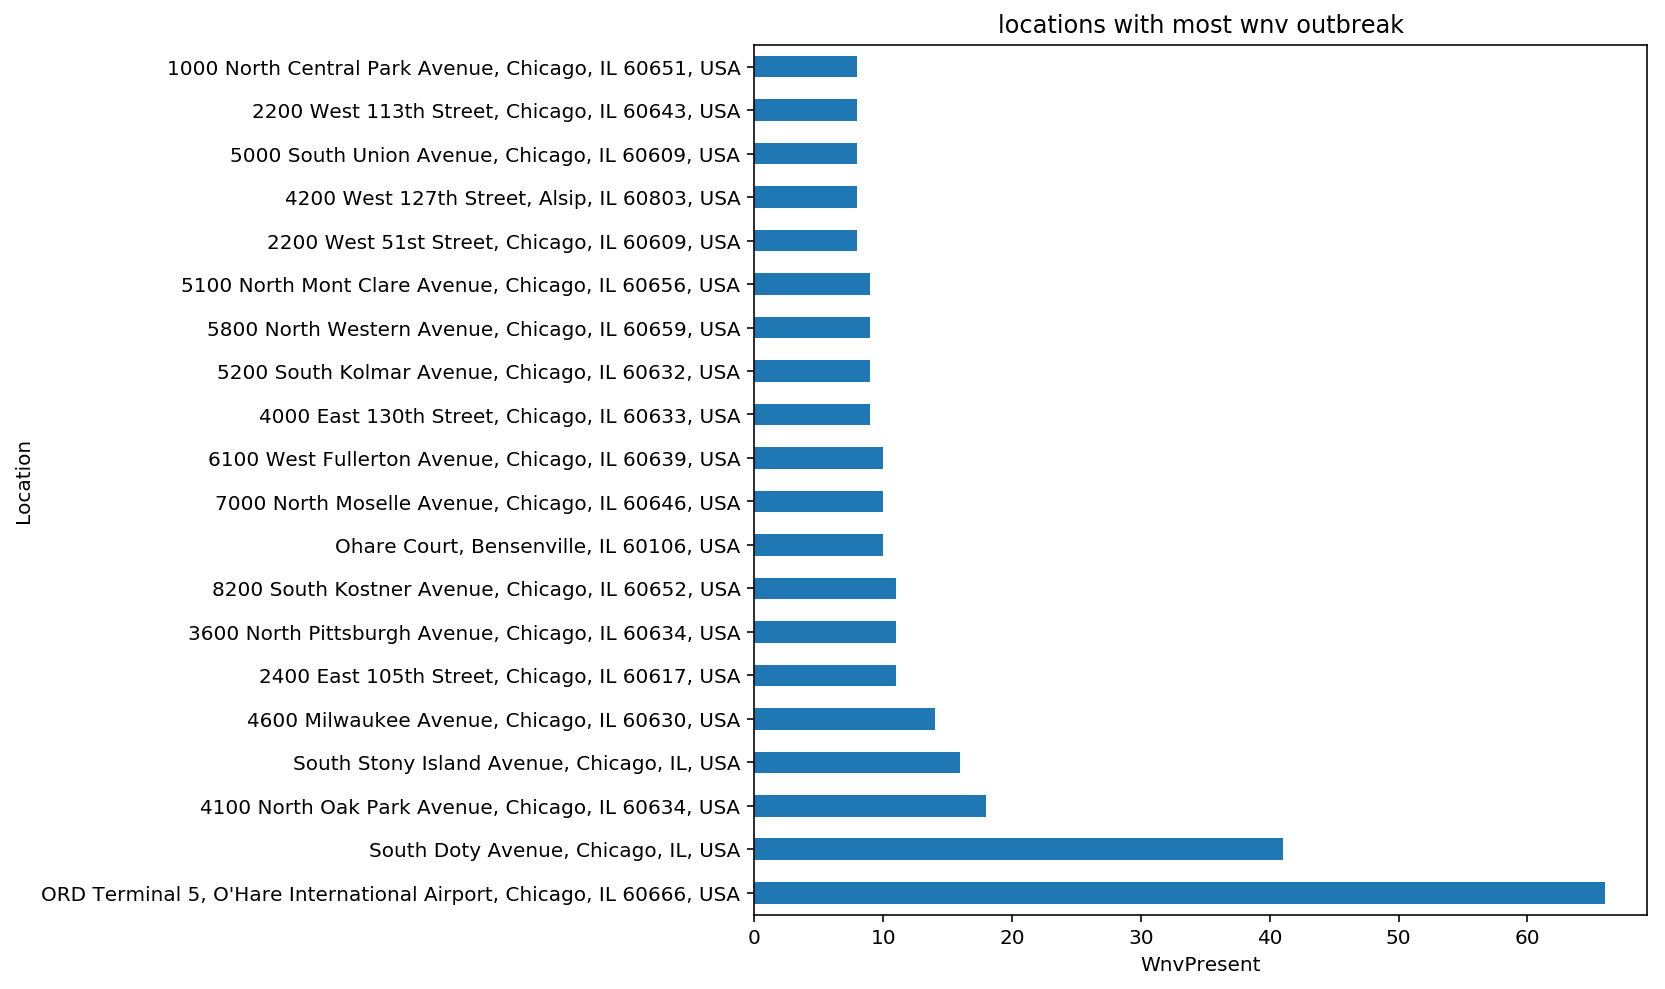

In [310]:
# Graph showing location with most wnv outbreak 
fig, ax = plt.subplots(figsize = (8, 8))
wnv_set.groupby('Address')['WnvPresent'].count().sort_values(ascending=False).head(20).plot(
    'barH',ax=ax, title = 'locations with most wnv outbreak')
plt.xlabel('WnvPresent')
plt.ylabel('Location')

In [311]:
# Location with the most Weather(Heat) condition (Mean)
wnv_set.groupby(['Latitude','Longitude'])['HeatMonthAvg'].mean().reset_index().sort_values(by='HeatMonthAvg',ascending=False).head(3)

,Latitude,Longitude,HeatMonthAvg
41,41.800737,-87.711880,7.0
32,41.772846,-87.740029,7.0
76,41.948167,-87.730698,5.0


In [312]:
# Location with the most Weather(Heat) condition (Sum)

wnv_set.groupby(['Latitude','Longitude'])['HeatMonthAvg'].sum().reset_index().sort_values(by='HeatMonthAvg',ascending=False).head(3)

,Latitude,Longitude,HeatMonthAvg
86,41.974689,-87.890615,48
82,41.964242,-87.757639,19
3,41.673408,-87.599862,18


Text(0,0.5,'Location')

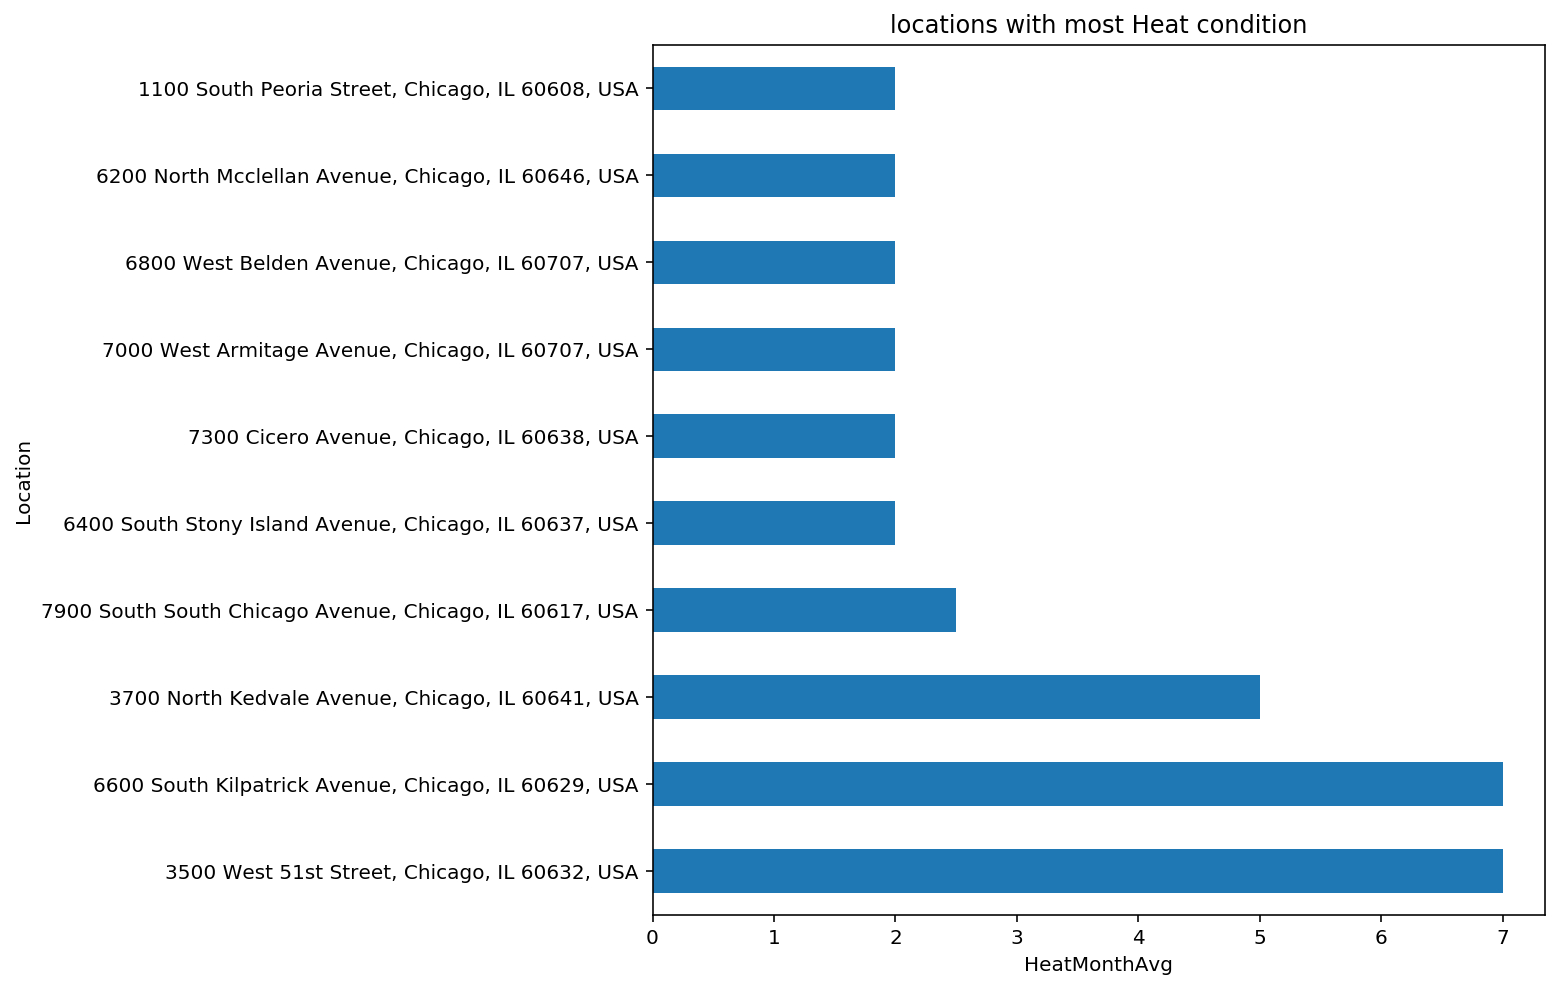

In [313]:
# Graph showing location with most Heat (mean)
fig, ax = plt.subplots(figsize = (8, 8))
wnv_set.groupby('Address')['HeatMonthAvg'].mean().sort_values(ascending=False).head(10).plot(
    'barH',ax = ax, title = 'locations with most Heat condition')
plt.xlabel('HeatMonthAvg')
plt.ylabel('Location')

Text(0,0.5,'Location')

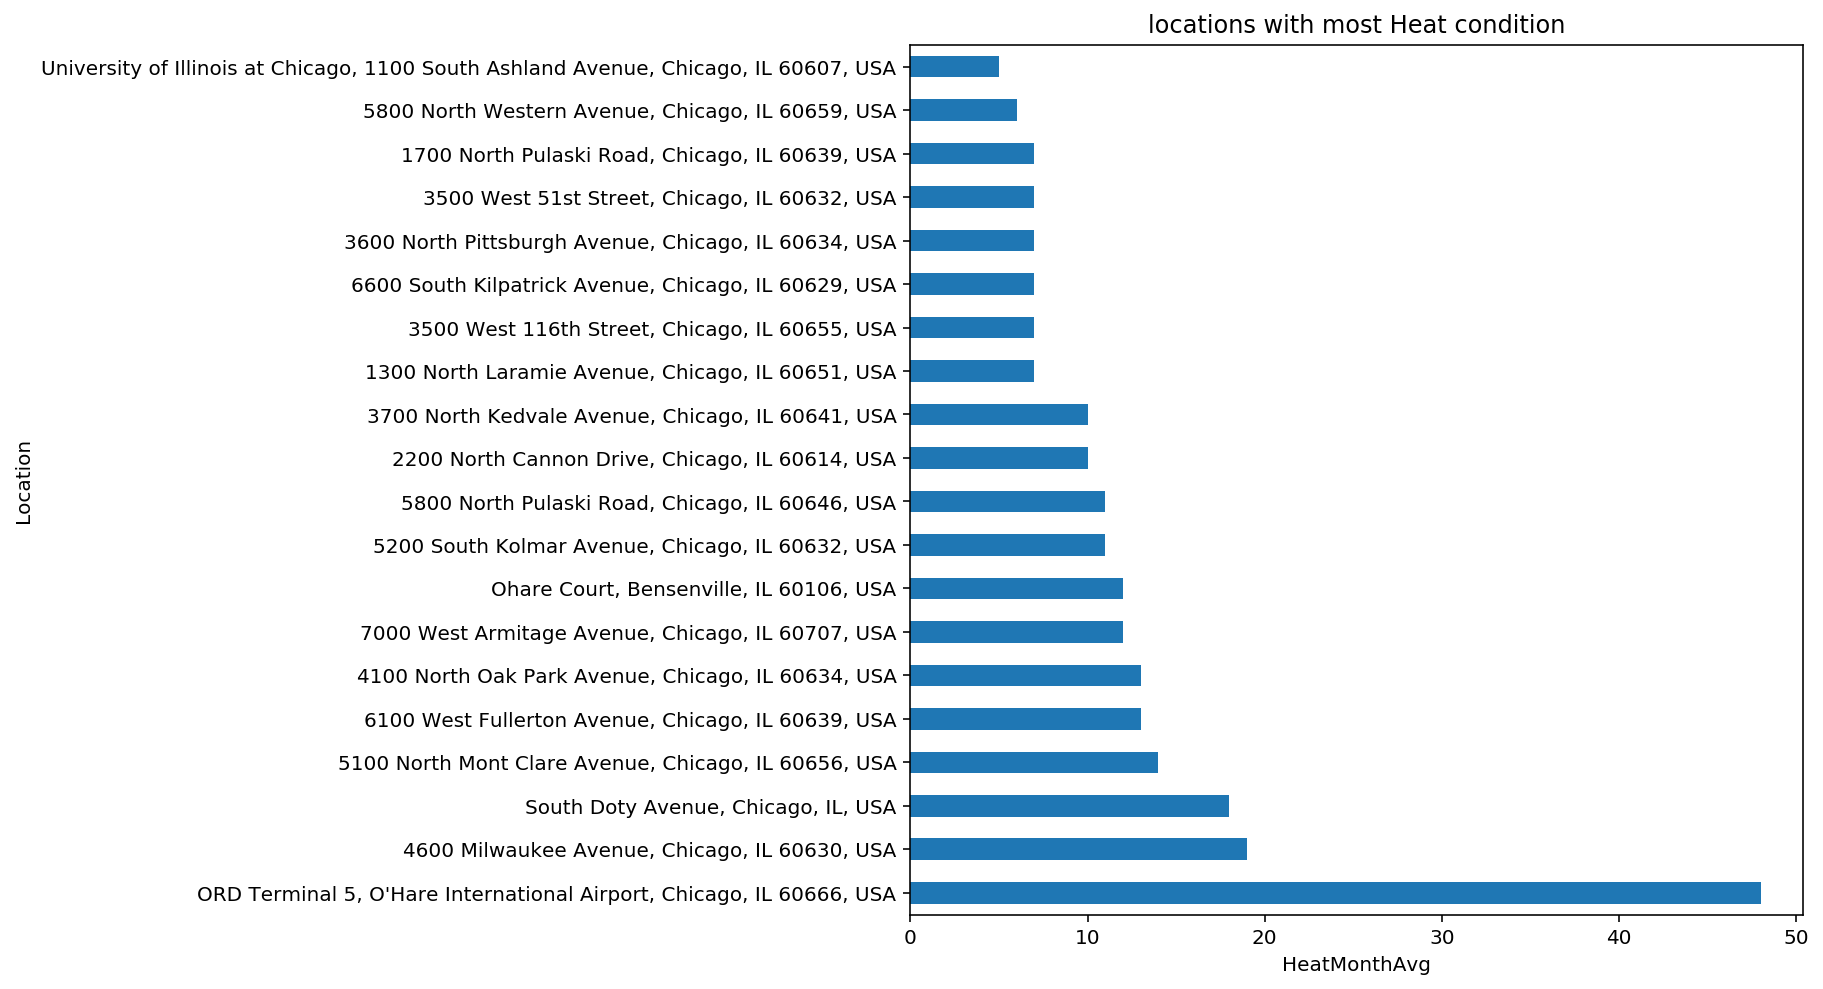

In [314]:
# Graph showing location with most Heat (Sum)
fig, ax = plt.subplots(figsize = (8, 8))
wnv_set.groupby('Address')['HeatMonthAvg'].sum().sort_values(ascending=False).head(20).plot(
    'barH',ax=ax, title = 'locations with most Heat condition')
plt.xlabel('HeatMonthAvg')
plt.ylabel('Location')

In [315]:
# Location with the most Weather(Precipitate) condition (Sum)
wnv_set.groupby(['Latitude','Longitude'])['PrecipMonthAvg'].sum().reset_index().sort_values(by='PrecipMonthAvg',ascending=False).head(3)

,Latitude,Longitude,PrecipMonthAvg
3,41.673408,-87.599862,8.9438
86,41.974689,-87.890615,6.5452
17,41.726465,-87.585413,4.6455


In [317]:
# Location with the most Weather(Precipitate) condition (Mean)
wnv_set.groupby(['Latitude','Longitude'])['PrecipMonthAvg'].mean().reset_index().sort_values(
    by='PrecipMonthAvg',ascending=False).head(3)

,Latitude,Longitude,PrecipMonthAvg
0,41.644612,-87.604498,0.3067
72,41.940160,-87.794896,0.3067
39,41.797616,-87.797894,0.3067


Text(0,0.5,'Location')

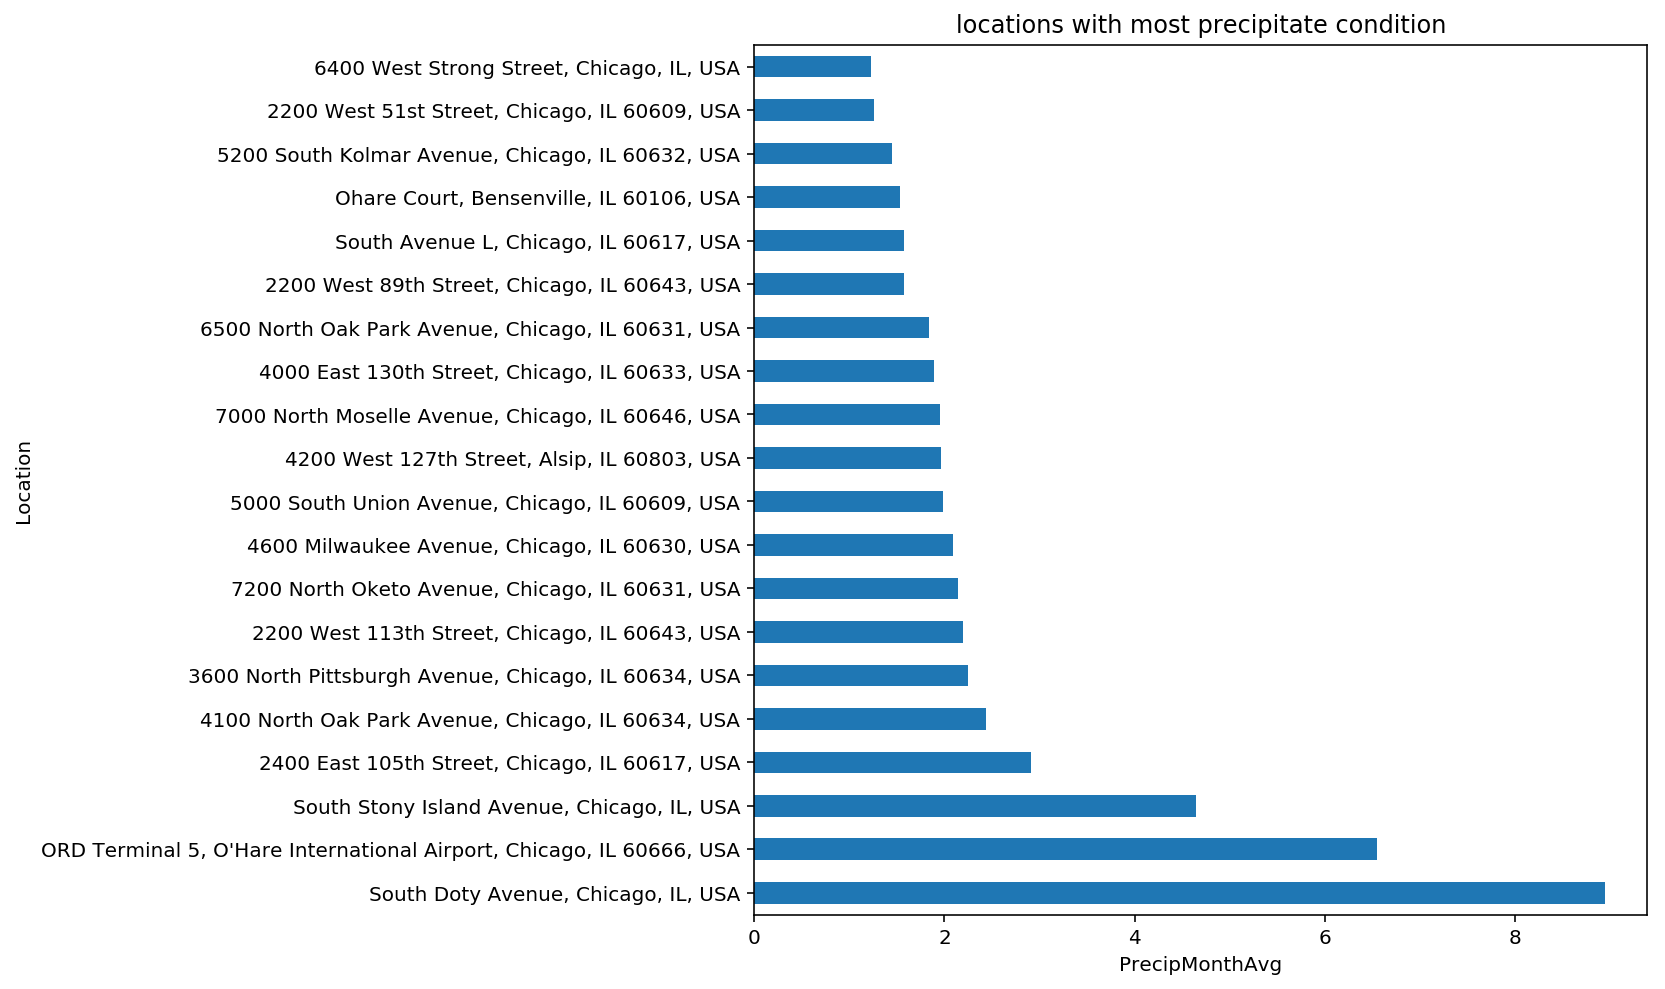

In [318]:
# Graph showing location with most Precipitata weather condition (Sum)
fig, ax = plt.subplots(figsize = (8, 8))
wnv_set.groupby('Address')['PrecipMonthAvg'].sum().sort_values(ascending=False).head(20).plot(
    'barH',ax=ax, title = 'locations with most precipitate condition')
plt.xlabel('PrecipMonthAvg')
plt.ylabel('Location')

Text(0,0.5,'Location')

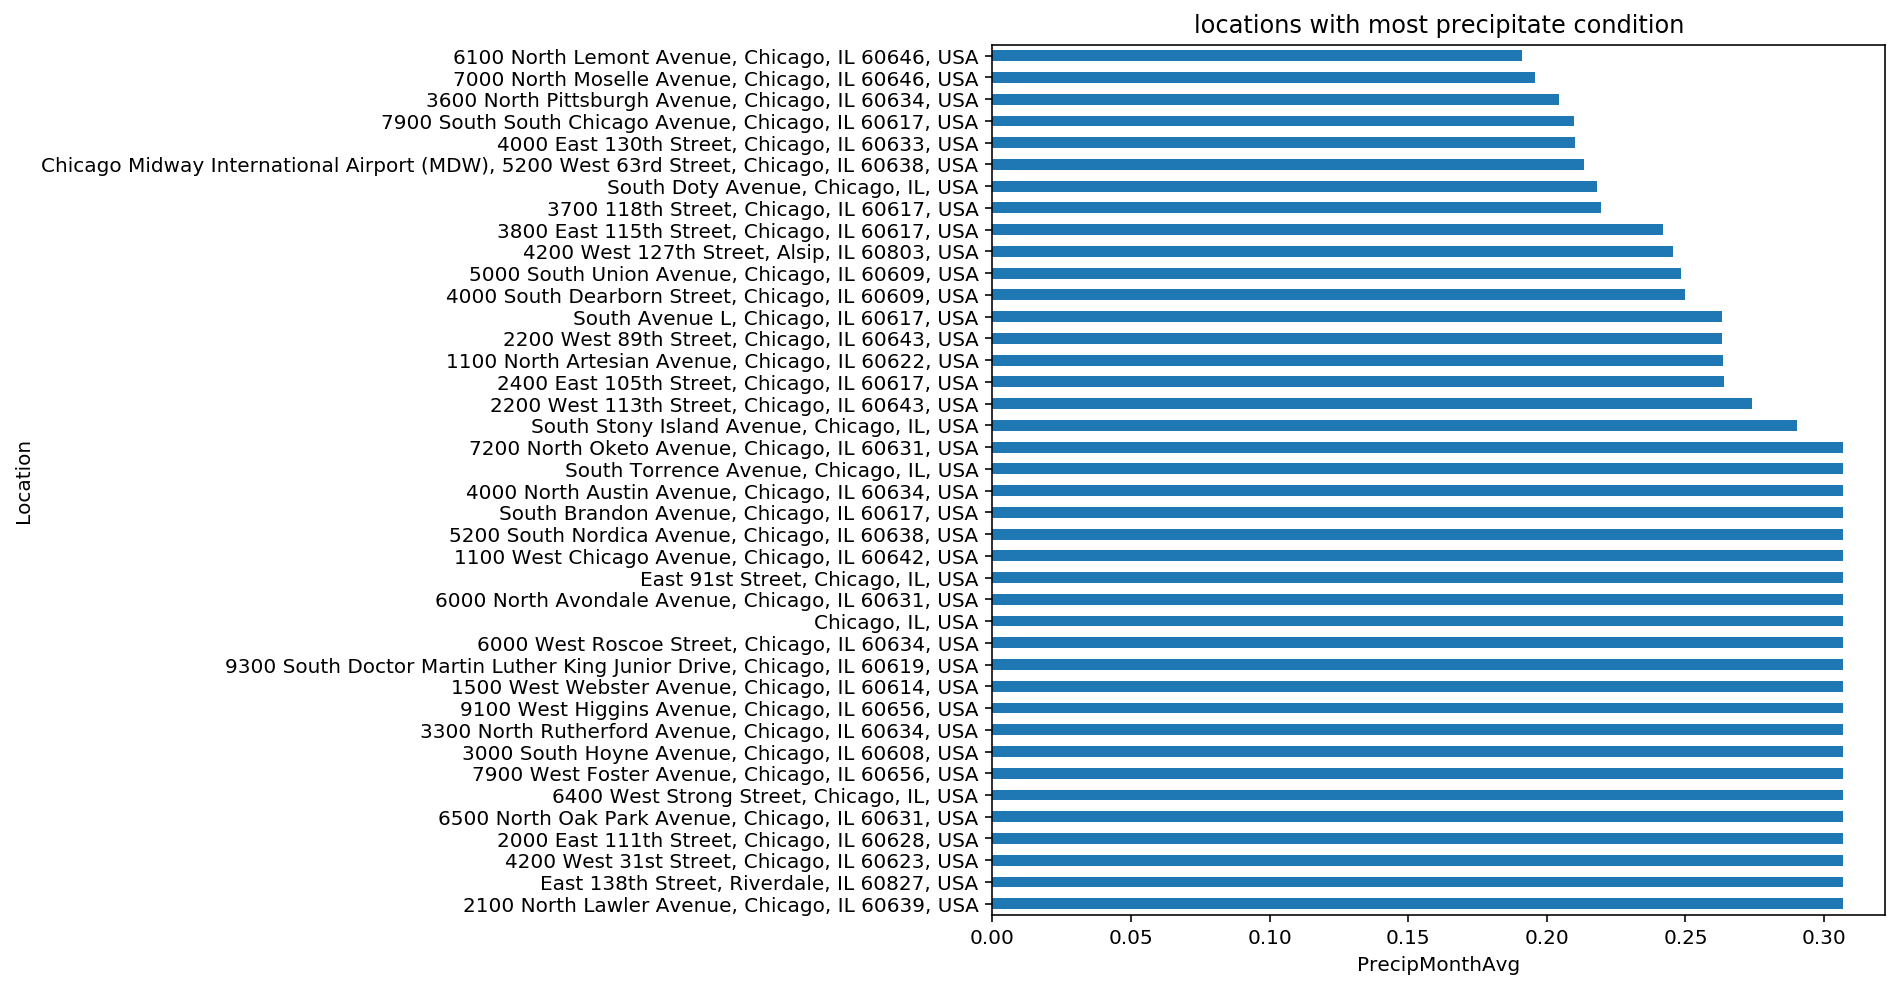

In [319]:
# Graph showing location with most Precipitate weather condition
fig, ax = plt.subplots(figsize = (8, 8))
wnv_set.groupby('Address')['PrecipMonthAvg'].mean().sort_values(ascending=False).head(40).plot(
    'barH',ax=ax, title = 'locations with most precipitate condition')
plt.xlabel('PrecipMonthAvg')
plt.ylabel('Location')

In [320]:
# Location with the most Weather(WetBulbMonthAvg) condition (Mean)
wnv_set.groupby(['Latitude','Longitude'])['WetBulbMonthAvg'].mean().reset_index().sort_values(
    by='WetBulbMonthAvg',ascending=False).head(3)

,Latitude,Longitude,WetBulbMonthAvg
0,41.644612,-87.604498,68.0
72,41.940160,-87.794896,68.0
39,41.797616,-87.797894,68.0


In [403]:
# Location with the most Weather(WetBulbMonthAvg) condition (Sum)
wnv_set.groupby(['Latitude','Longitude'])['WetBulbMonthAvg'].sum().reset_index().sort_values(
    by='WetBulbMonthAvg',ascending=False).head(3)

,Latitude,Longitude,WetBulbMonthAvg
86,41.974689,-87.890615,4254
3,41.673408,-87.599862,2697
79,41.954690,-87.800991,1161


Text(0,0.5,'Location')

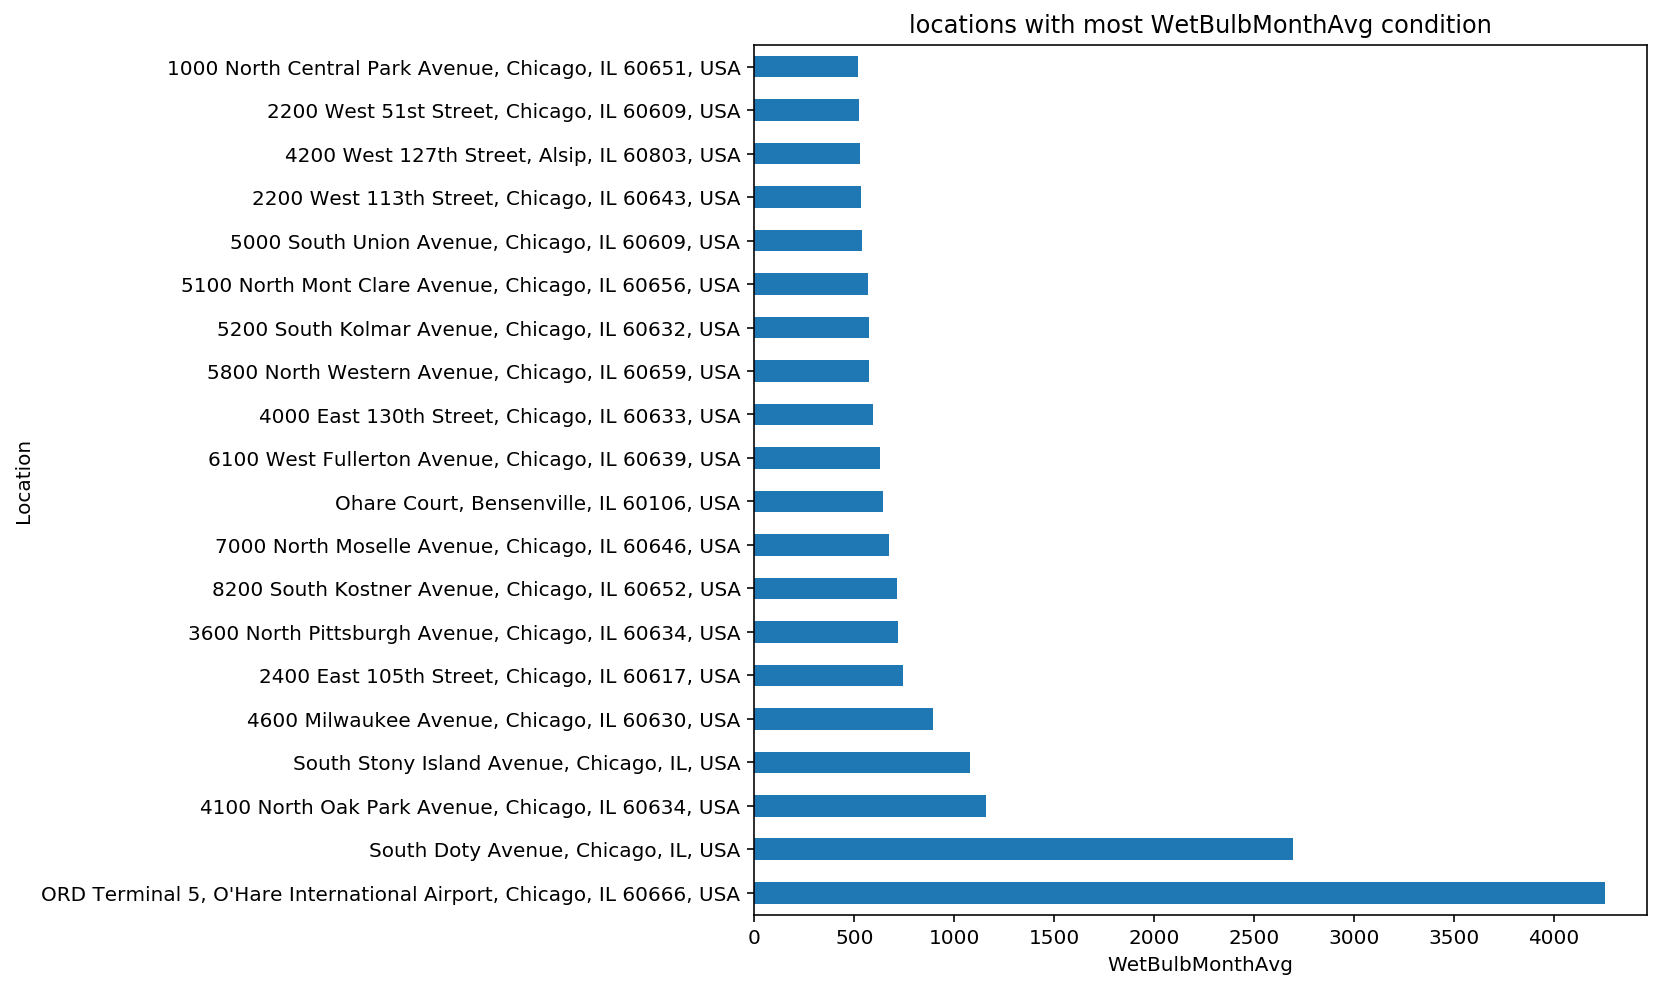

In [322]:
# Graph showing location with most WetBulbMonthAvg
fig, ax = plt.subplots(figsize = (8, 8))
wnv_set.groupby('Address')['WetBulbMonthAvg'].sum().sort_values(ascending=False).head(20).plot(
    'barH',ax=ax, title = 'locations with most WetBulbMonthAvg condition')
plt.xlabel('WetBulbMonthAvg')
plt.ylabel('Location')

In [323]:
# Location with the most Weather(Cool) condition (Mean)
wnv_set.groupby(['Latitude','Longitude'])['CoolMonthAvg'].mean().reset_index().sort_values(
    by='CoolMonthAvg',ascending=False).head(3)

,Latitude,Longitude,CoolMonthAvg
0,41.644612,-87.604498,10.0
19,41.729669,-87.582699,10.0
29,41.766202,-87.562889,10.0


In [324]:
# Location with the most Weather(Cool) condition (Mean)
wnv_set.groupby(['Latitude','Longitude'])['CoolMonthAvg'].sum().reset_index().sort_values(
    by='CoolMonthAvg',ascending=False).head(3)

,Latitude,Longitude,CoolMonthAvg
86,41.974689,-87.890615,541
3,41.673408,-87.599862,364
17,41.726465,-87.585413,156


Text(0,0.5,'Location')

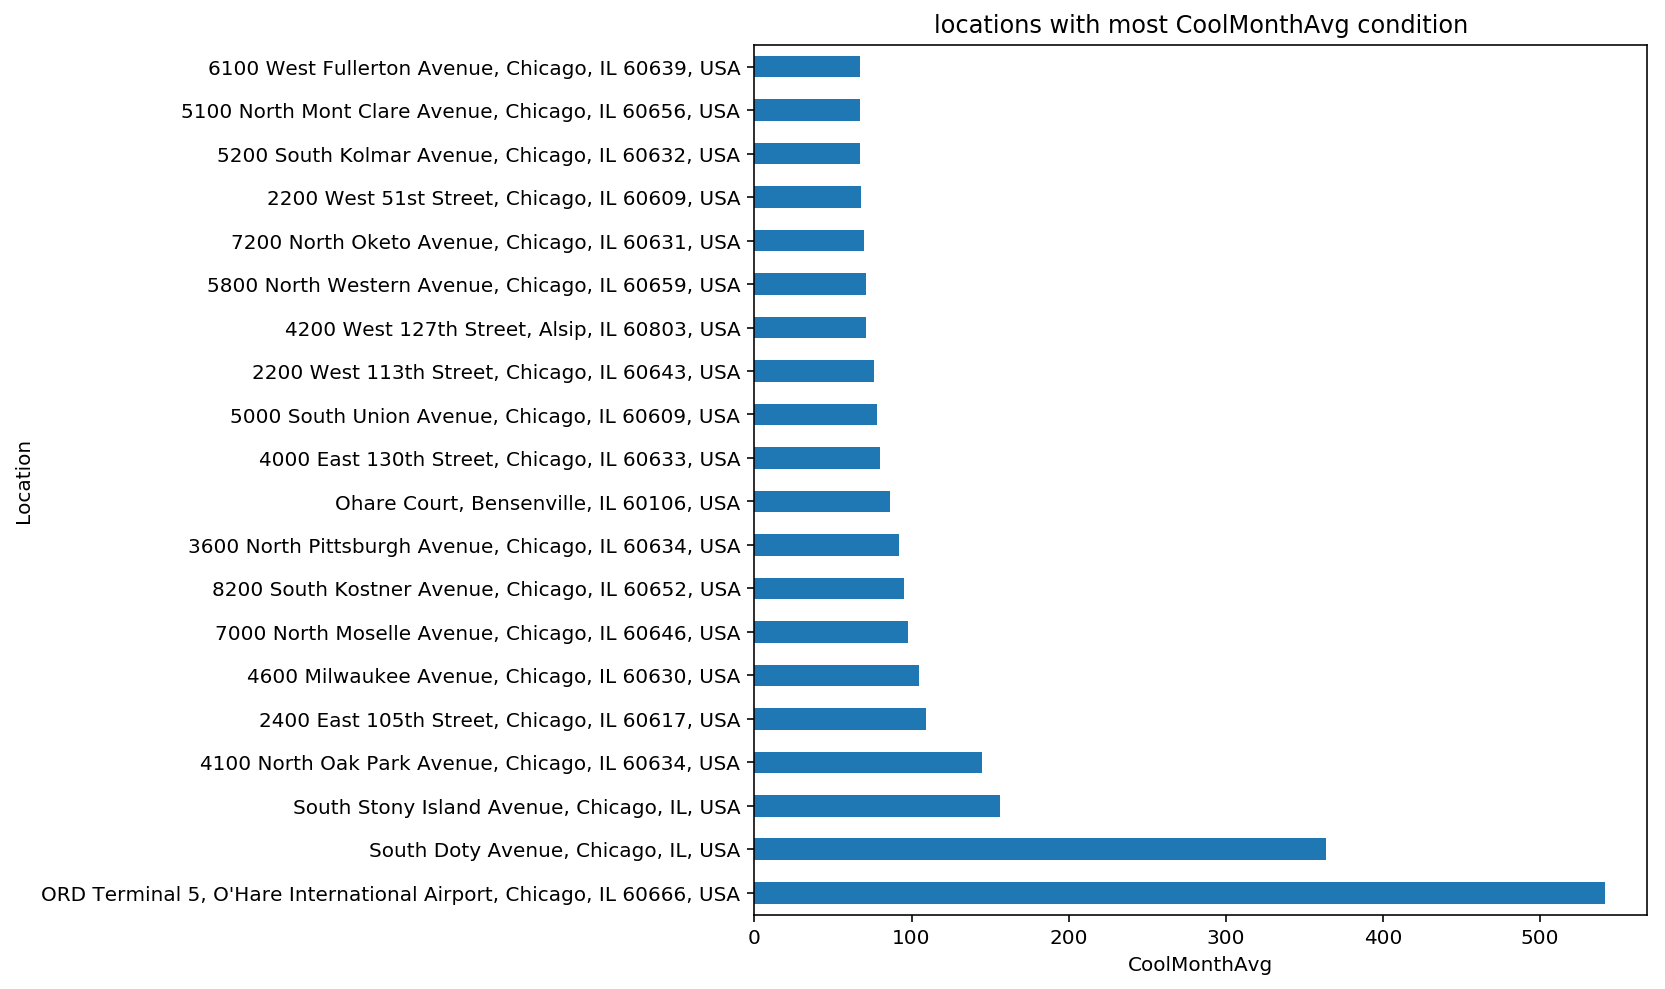

In [325]:
# Graph showing location with most CoolMonthAvg
fig, ax = plt.subplots(figsize = (8, 8))
wnv_set.groupby('Address')['CoolMonthAvg'].sum().sort_values(ascending=False).head(20).plot(
    'barH',ax=ax, title = 'locations with most CoolMonthAvg condition')
plt.xlabel('CoolMonthAvg')
plt.ylabel('Location')

In [326]:
# Location with the most Weather(DewPointMonthAvg) condition
wnv_set.groupby(['Latitude','Longitude'])['DewPointMonthAvg'].sum().reset_index().sort_values(
    by='DewPointMonthAvg',ascending=False).head(3)

,Latitude,Longitude,DewPointMonthAvg
86,41.974689,-87.890615,3886
3,41.673408,-87.599862,2503
79,41.954690,-87.800991,1064


Text(0,0.5,'Location')

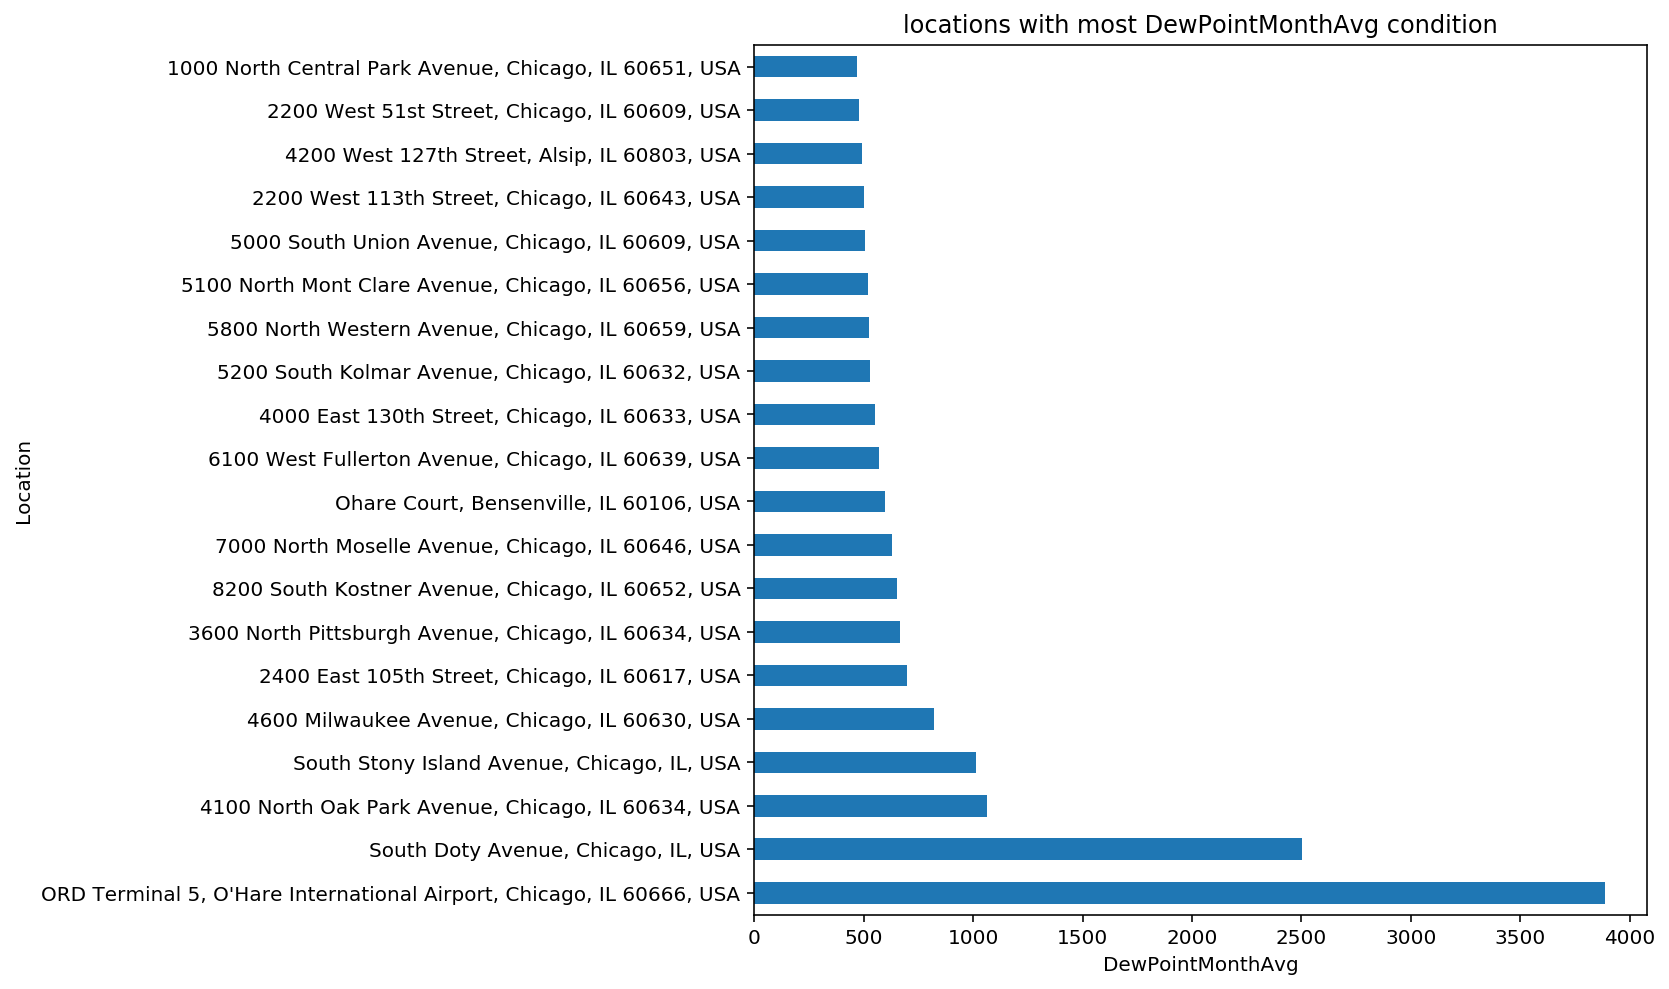

In [327]:
# Graph showing location with most DewPointMonthAvg
fig, ax = plt.subplots(figsize = (8, 8))
wnv_set.groupby('Address')['DewPointMonthAvg'].sum().sort_values(ascending=False).head(20).plot(
    'barH',ax=ax, title = 'locations with most DewPointMonthAvg condition')
plt.xlabel('DewPointMonthAvg')
plt.ylabel('Location')